In [1]:
import numpy as np
from pathlib import Path
import h5py
from tqdm import tqdm
from itertools import product
import multiprocessing as mp

In [2]:
import matplotlib.pyplot as plt

In [3]:
from robust_motifs.data import (save_count_graph_from_matrix, matrix_shuffle,
                                load_bbp_matrix_format, adjust_bidirectional_edges,
                               load_sparse_matrix_from_pkl)
from robust_motifs.custom_mp import prepare_shared_memory
from robust_motifs.counting import get_bisimplices

In [4]:
path = Path("data/data_daniela/O1_matrix/matrix_O1_col2.npy")
original_matrix = load_bbp_matrix_format(path)

pathway_shuffled_matrix = load_bbp_matrix_format(path, shuffle_type="pathway")

shuffled_matrix = load_bbp_matrix_format(path, shuffle_type="all")

100%|██████████| 55/55 [08:10<00:00,  8.93s/it]


In [5]:
original_matrix.multiply(original_matrix.T)

pathway_shuffled_matrix.multiply(pathway_shuffled_matrix.T)

shuffled_matrix.multiply(shuffled_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 61536 stored elements in Compressed Sparse Row format>

In [6]:
bid_adjusted_matrix = adjust_bidirectional_edges(shuffled_matrix, int(182932/2))

Adding bidirectional edges...: 100%|██████████| 60698/60698 [00:00<00:00, 159095.68it/s]


In [7]:
bid_adjusted_matrix.multiply(bid_adjusted_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 182932 stored elements in Compressed Sparse Row format>

### Processing

In [8]:
overall_results = [{},{},{},{}]

### Column

In [9]:
save_path = Path("data/models/column/column.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, original_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3252551.91it/s]
7803528it [00:11, 680592.33it/s]


In [10]:
pool = mp.Pool()

In [11]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[0][dimension] = overall_results[0].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4046, 2: 513, 3: 87, 4: 26, 5: 4, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4173, 2: 481, 3: 74, 4: 16, 5: 2, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4240, 2: 486, 3: 94, 4: 16, 5: 2, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4108, 2: 468, 3: 83, 4: 12, 5: 5, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4165, 2: 501, 3: 84, 4: 20, 5: 6, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4074, 2: 517, 3: 80, 4: 20, 5: 3, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4121, 2: 516, 3: 89, 4: 19, 5: 3, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4118, 2: 488, 3: 89, 4: 14, 5: 2, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 4157, 2: 533, 3: 96, 4: 22, 5: 1, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


100%|██████████| 6/6 [02:07<00:00, 21.27s/it]

Extended simplices for 10000 simplices per dimension
{1: 4102, 2: 482, 3: 89, 4: 20, 5: 2, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 76936601, 3: 65939554, 4: 7637507, 5: 163019, 6: 808}


<BarContainer object of 6 artists>

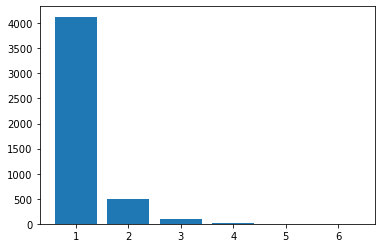

In [12]:
a = []
b = []
for elem in overall_results[0].values():
    a.append(np.mean(elem))
plt.bar(range(1,7), a)

### Pathway shuffled

In [13]:
save_path = Path("data/models/pshuffled/pshuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, pathway_shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3130647.04it/s]
7803528it [00:11, 663719.88it/s]


In [14]:
pool = mp.Pool()

In [15]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[1][dimension] = overall_results[1].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 490, 2: 10, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 468, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 488, 2: 8, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 475, 2: 9, 3: 1, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 457, 2: 9, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 495, 2: 12, 3: 2, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 505, 2: 10, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 470, 2: 18, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 469, 2: 7, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


100%|██████████| 6/6 [01:02<00:00, 10.35s/it]

Extended simplices for 10000 simplices per dimension
{1: 542, 2: 14, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 26656484, 3: 1690177, 4: 2489, 5: 0, 6: 0}


<BarContainer object of 6 artists>

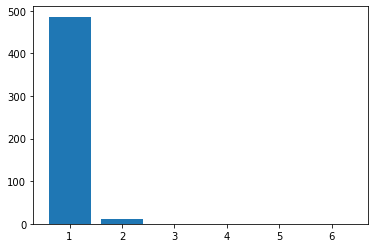

In [16]:
a = []
b = []
for elem in overall_results[1].values():
    a.append(np.mean(elem))
plt.bar(range(1,7), a)

### ER

In [17]:
save_path = Path("data/models/shuffled/shuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3090176.59it/s]
7803528it [00:11, 661734.87it/s]


In [18]:
pool = mp.Pool()

In [19]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[2][dimension] = overall_results[2].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 160, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 181, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 156, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 169, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 160, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 136, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 155, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 151, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 153, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


100%|██████████| 6/6 [00:52<00:00,  8.81s/it]

Extended simplices for 10000 simplices per dimension
{1: 147, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431743, 3: 242897, 4: 27, 5: 0, 6: 0}


<BarContainer object of 6 artists>

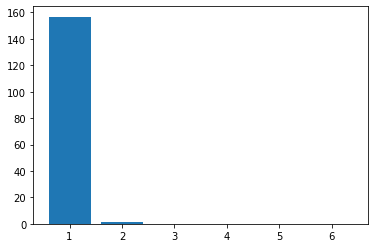

In [20]:
a = []
b = []
for elem in overall_results[2].values():
    a.append(np.mean(elem))
plt.bar(range(1,7), a)

### ER bid adjusted

In [21]:
save_path = Path("data/models/adjusted/adjusted.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, bid_adjusted_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 2919777.33it/s]
7803528it [00:11, 658164.44it/s]


In [22]:
pool = mp.Pool()

In [23]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_bisimplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, set()).union(set(elem))
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = set()
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        result_dictionary[dimension] = len(result_dictionary[dimension])
        
        overall_results[3][dimension] = overall_results[3].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 449, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 450, 2: 5, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 487, 2: 7, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 470, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 470, 2: 6, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 457, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 504, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 477, 2: 5, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 470, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


100%|██████████| 6/6 [01:01<00:00, 10.21s/it]

Extended simplices for 10000 simplices per dimension
{1: 455, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0}
Total simplices per dimension
{1: 7803528, 2: 15431690, 3: 242981, 4: 30, 5: 0, 6: 0}


<BarContainer object of 6 artists>

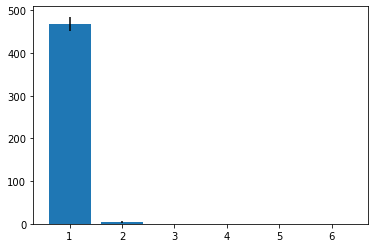

In [24]:
a = []
b = []
for elem in overall_results[3].values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

Text(0, 0.5, 'Extended simplices / simplex')

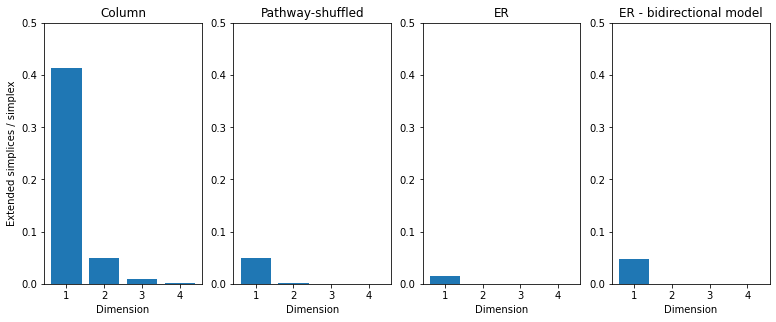

In [27]:
img, axes = plt.subplots(1,4,figsize = [13, 4.8])
titles = ["Column", "Pathway-shuffled", "ER", "ER - bidirectional model"]
s_d4 = [6599529, 2489, 27, 30]
for ax, dicts, title, s in zip(axes, overall_results, titles, s_d4):
    a = []
    for elem in dicts.values():
        a.append(np.mean(elem)/10000)
    a[3] = a[3]*10000/min(10000, s)
    ax.bar(range(1,5), a[:4])
    ax.set_xlabel("Dimension")
    ax.set_ylim(0,0.5)
    ax.set_title(title)
axes[0].set_ylabel("Extended simplices / simplex")

In [28]:
img.savefig(fname = "Comparison bisimplices 2", transparent=False, facecolor = "white")